In [14]:
from earthai.all import *
import geopandas as gpd

from requests import HTTPError

In [2]:
macro_10km_shp = "../../resources/nt-model/10km_CS_macro/macroloc_cement_steel_CHN_10.shp"

CRS:  epsg:4326
Number of grid cells in 10km CS Macro:  47233


<AxesSubplot:>

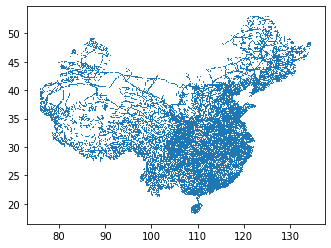

In [3]:
macro_10km_gdf = gpd.read_file(macro_10km_shp)
print("CRS: ", macro_10km_gdf.crs)
print("Number of grid cells in 10km CS Macro: ", len(macro_10km_gdf))
macro_10km_gdf.plot()

### Add small buffer to geometries in grid

*Note: 1 arcsec = 0.00028 deg ~ 30m at the equator.*

In [5]:
macro_10km_gdf = gpd.GeoDataFrame({'index': macro_10km_gdf.index,
                                   'geometry': macro_10km_gdf.buffer(0.00028*35)},
                                   geometry='geometry',
                                   crs='EPSG:4326')

### Union to create simplier DataFrame of deployment region

In [8]:
macro_deployment_gdf = gpd.GeoDataFrame({'region': '10km Grid',
                                   'geometry': macro_10km_gdf.unary_union},
                                   geometry='geometry',
                                   crs='EPSG:4326')

## Get catalog of Landsat 8 scenes that intersect with grid cells

### Plan A: use `macro_deployment_gdf` (183 rows). Fails.

In [15]:
try:
    site_cat_2020_04 = earth_ondemand.read_catalog(
        geo=macro_deployment_gdf,
        start_datetime='2020-04-01', 
        end_datetime='2020-04-15',
        max_cloud_cover=100,
        collections='landsat8_l1tp'
    )
except HTTPError as e:
    bad_response = e.response
    bad_request = e.response.request

In [19]:
bad_request.body

'intersects=%7B%22type%22%3A+%22FeatureCollection%22%2C+%22features%22%3A+%5B%7B%22id%22%3A+%220%22%2C+%22type%22%3A+%22Feature%22%2C+%22properties%22%3A+%7B%7D%2C+%22geometry%22%3A+%7B%22type%22%3A+%22Polygon%22%2C+%22coordinates%22%3A+%5B%5B%5B109.97572749999807%2C+18.401009199999507%5D%2C+%5B109.97572749999807%2C+18.310809199999504%5D%2C+%5B109.97568031031946%2C+18.309848632024273%5D%2C+%5B109.97553919574602%2C+18.308897314843747%5D%2C+%5B109.97530551528826%2C+18.30796441016241%5D%2C+%5B109.97498151941669%2C+18.307058902362325%5D%2C+%5B109.9745703283887%2C+18.30618951197861%5D%2C+%5B109.97407590219863%2C+18.305364611715913%5D%2C+%5B109.97350300244103%2C+18.3045921458147%5D%2C+%5B109.9728571464537%2C+18.303879553543876%5D%2C+%5B109.97214455418288%2C+18.30323369755655%5D%2C+%5B109.97137208828167%2C+18.30266079779894%5D%2C+%5B109.97054718801897%2C+18.30216637160889%5D%2C+%5B109.96967779763526%2C+18.301755180580894%5D%2C+%5B109.96877228983517%2C+18.30143118470933%5D%2C+%5B109.9678393851

### Plan B: use macro_10km_gdf (47,233 rows). Fails.

In [12]:
site_cat_2020_04 = earth_ondemand.read_catalog(
    geo=macro_10km_gdf,
    start_datetime='2020-04-01', 
    end_datetime='2020-04-15',
    max_cloud_cover=100,
    collections='landsat8_l1tp'
)

HTTPError: 500 Server Error: Internal Server Error for url: https://eod-catalog-svc-prod.astraea.earth/search

### Plan C: Read in smaller abount of rows. Up to 2000 works. Fails at 2500.

In [13]:
site_cat_2020_04 = earth_ondemand.read_catalog(
    geo=macro_10km_gdf[0:2000],
    start_datetime='2020-04-01', 
    end_datetime='2020-04-15',
    max_cloud_cover=100,
    collections='landsat8_l1tp'
)